In [88]:
#Description TODO
from pyspark import SparkConf, SparkContext, HiveContext

sc.stop()
conf = SparkConf().set("spark.executor.instances", 32).set("spark.driver.maxResultSize", "8g")
sc = SparkContext(conf=conf)

hc = HiveContext(sc)
table_name = 'user_kposminin.urls_w_levels1'
query2 = '''
select * from {0}
where hash(cookie) % 19 = 0
'''.format(table_name)

#hc.sql(query2[0])
#hc.sql(query2[1])

rdd = hc.sql(query2).rdd 


In [89]:
#Group by cookie and form url list the cookie visited
def test(id):
    ''' Is id (==cookie + '-'+date) is from test sample or not(=train sample)? True or False
        In ths case test sample == sample from May month.    
    '''
    import re
    return int(re.findall('[0-9]{4}-([0-9]{2})-[0-9]{2}',id)[0]) == 5

    
rdd2 = rdd.flatMap(lambda row: [(row['cookie'] + str(test(row['object_id'])) , row['domain']),
                                (row['cookie'] + str(test(row['object_id'])), row['domain']+'[0]'+row['lev0']),
                                (row['cookie'] + str(test(row['object_id'])), row['domain']+'[1]'+row['lev1']),
                                (row['cookie'] + str(test(row['object_id'])), row['domain']+'[2]'+row['lev2']),
                                (row['cookie'] + str(test(row['object_id'])), row['domain']+'[r]'+row['ref_domain']),
                                (row['cookie'] + str(test(row['object_id'])), row['domain']+'[r0]'+row['ref_lev0']),
                                (row['cookie'] + str(test(row['object_id'])), row['domain']+'[r1]'+row['ref_lev1']),
                                (row['cookie'] + str(test(row['object_id'])), row['domain']+'[r2]'+row['ref_lev2'])
]).reduceByKey(lambda a,b: a + ';;' + b)
#rdd2 = rdd.map(lambda row: (row['cookie'] , row['domain'])).reduceByKey(lambda a, b: a + ';;' + b)

# Label target cookies (=cookies visited target url) and exclude some urls
import re
#target_urls =['mkb.ru/facility/private_person/cards/credit_card','mkb.ru']
target_urls =['avito.ru']
exclude_urls = target_urls + []

def handle_row(row,targ_urls, exclud_urls):
    proc_urls = row[1]
    for u in exclud_urls:
        proc_urls = re.sub('[^;;]*'+ u +'[^;;]*','',proc_urls)
    return (
        any(tu in row[1] for tu in targ_urls), 
        re.sub('[;]{3,}',';;',proc_urls)
    )

rdd3 = rdd2.map(lambda row: handle_row(row,target_urls, exclude_urls))

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.classification import LogisticRegressionWithSGD, NaiveBayes, NaiveBayesModel

tf = HashingTF(numFeatures = 10 ** 4)

#transform urls (as Bag of Words) into features and form features with labels
all_data = rdd3.map(lambda row: LabeledPoint(row[0], tf.transform(row[1].split(';;'))))
# TODO count visits or not
# split into train and test samples
train_data, test_data = all_data.randomSplit([6, 4])

In [90]:
#Train model
train_data.cache()
model = NaiveBayes.train(train_data)

def predict_proba_NB(f,model):
    import numpy as np
    '''
    Naive Bayes model prediction with probability. f is features [Sparse] vector. model is mllib.NaiveBayesModel.
    Function selects winning class with it probability.
    Output: tuple with model selected class number as first element (type int) and it probability as second (type float).
    '''
    logp = [[i,f.dot(model.theta[i]) + model.pi[i]] for i in range(len(model.theta))] # classes with log probabilities
    wi = sorted(logp, key = lambda e:  - e[1])[0][0] #winning index
    prob = 1./sum([np.exp(e[1] - logp[wi][1]) for e in logp]) #winning class probability
    return wi, prob

def predict_proba_NB_2(f, model):
    import numpy as np
    '''
    Naive Bayes model prediction with probability for 2-class classification.
    f is features [Sparse] vector. model is mllib.NaiveBayesModel.
    Output: probability of class 1 (type float).
    '''
    if len(model.theta) != 2:
        print('Model is NOT a 2-class classifier')
        return None
    logp = [f.dot(model.theta[i]) + model.pi[i] for i in range(2)]    
    return 1./(1. + np.exp(logp[0] - logp[1]))
    
#Testing result
test_res = test_data.map(lambda lp: (predict_proba_NB_2(lp.features, model),lp.label)) #.sortByKey(ascending = False)

In [91]:
import sklearn
test_res_list = test_res.collect()
aucroc = sklearn.metrics.roc_auc_score(
        [e[1] for e in test_res_list],
        [e[0] for e in test_res_list]
)
aucroc

0.75152601999024649

In [92]:
id = '83718619B80DB268A1CE-2016-06-04'
test(id)

False

In [60]:
for f in test_data.top(50):
    ex = f.features
    p = []
    for i in [0,1]:
        p.append(ex.dot(model.theta[i]) + model.pi[i])
        print('{0} class log probability: {1}'.format(i, p[i]))
    print('{0}.     model prediction is {1}.'.format((p[0] < p[1]) == model.predict(ex), model.predict(ex)))
    print(predict_proba_NB(ex,model))
    print(predict_proba_NB_2(ex,model))
    print('-'*5)

0 class log probability: -619.957533125
1 class log probability: -3131.73194761
True.     model prediction is 0.0.
(0, 1.0)
0.0
-----
0 class log probability: -134.270812141
1 class log probability: -123.060793405
True.     model prediction is 1.0.
(1, 0.99998646230137556)
0.999986462301
-----
0 class log probability: -27.6021001885
1 class log probability: -42.2886633545
True.     model prediction is 0.0.
(0, 0.99999958148938561)
4.18510614324e-07
-----
0 class log probability: -7.30620121256
1 class log probability: -10.2155865149
True.     model prediction is 0.0.
(0, 0.94830844063646769)
0.0516915593635
-----
0 class log probability: -24.150500498
1 class log probability: -26.0810285698
True.     model prediction is 0.0.
(0, 0.87330785791760546)
0.126692142082
-----
0 class log probability: -179.71064474
1 class log probability: -179.014984778
True.     model prediction is 1.0.
(1, 0.66722482859549426)
0.667224828595
-----
0 class log probability: -287.578280807
1 class log probabi

In [72]:
def calc_ROC(arr):
    ''''Calculates ROC curve from arr input with two columns: 
        first is classifier score and second is label (0 or 1). arr is sorted by score.
        Output is tuple with AUC ROC as first element and ROC array with two 
        columns FPR and TPR as second element.
    '''
    #cumulative positive, negative, true positive rate, false positive rate,
    # area under ROC curve
    TPR, FPR, AUC = 0., 0., 0.
    one_to_P = 1. / sum([e[1] for e in arr])
    one_to_N =  one_to_P / (len(arr) *  one_to_P - 1)
    ROC = []
    for e in arr:
        if e[1] == 0 :            
            FPR+= one_to_N
            AUC += TPR * one_to_N
        else:            
            TPR+= one_to_P
        ROC.append([FPR,TPR])
    return (AUC, ROC)
    
#test_res_list = sorted(test_res_list, key = lambda e: -e[0])
#res = calc_ROC(arr)    

/opt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


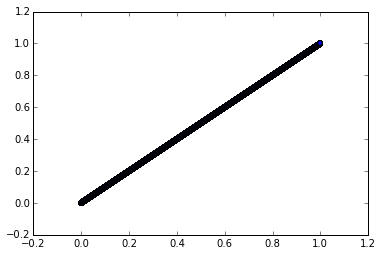

In [78]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plt.scatter([e[0] for e in res[1]],[e[0] for e in res[1]])

In [82]:
tf1 = HashingTF(numFeatures = 20 ) 
tf1.transform(['fF','EFE','AS'])

SparseVector(20, {1: 1.0, 14: 1.0, 18: 1.0})

TypeError: 'int' object is not iterable

In [4]:
import pandas as pd
pd.DataFrame([range(10),range(10)]).set_columns(['af','fg'])

AttributeError: 'DataFrame' object has no attribute 'set_columns'